In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

In [2]:
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
IMAGE_PATH = '../FloodNet_large/imgs/'
MASK_PATH = '../FloodNet_large/labels/'

In [4]:
n_classes = 10

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  2343


In [5]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  1791
Val Size     :  317
Test Size    :  235


Image Size (3000, 4000, 3)
Mask Size (3000, 4000)


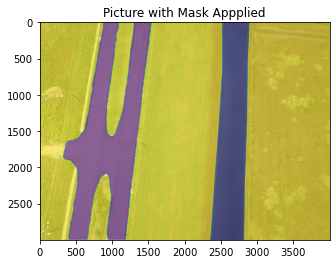

In [6]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '_lab.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [7]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        # numpy array contains all the ids
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '_lab.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704,1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704,1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)  

In [9]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  SFNet
    3  BiSeNetv1
    4  DDRNet
    5  FCHarDNet
    6  BiSeNetv2


In [10]:
from semseg.models import *

model = eval('BiSeNetv2')(
#     backbone='MobileNetV3',
    num_classes=10
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b3.ade.pth', map_location='cpu'))
except:
    print("Download a pretrained model's weights from the result table.")
model.eval()

print('Loaded Model')

Download a pretrained model's weights from the result table.
Loaded Model


In [11]:
model

BiSeNetv2(
  (detail_branch): DetailBranch(
    (S1): Sequential(
      (0): ConvModule(
        (0): QConv2d(
          3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
          (quantize_input): QuantMeasure()
        )
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): ConvModule(
        (0): QConv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (quantize_input): QuantMeasure()
        )
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (S2): Sequential(
      (0): ConvModule(
        (0): QConv2d(
          64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
          (quantize_input): QuantMeasure()
        )
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): R

In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
    
def mIoU_per_class(pred_mask, mask, smooth=1e-10, n_classes=10):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return iou_per_class

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            model.eval()
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'BiseNetV2_704-1056-mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-3
epoch = 60
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/597 [00:00<?, ?it/s]

C:\Users\fsafavi1\Anaconda3\envs\py37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/106 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.279 
Epoch:1/60.. Train Loss: 2.291.. Val Loss: 2.279.. Train mIoU:0.101.. Val mIoU: 0.094.. Train Acc:0.561.. Val Acc:0.543.. Time: 10.21m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Loss Decreasing.. 2.279 >> 2.248 
Epoch:2/60.. Train Loss: 2.263.. Val Loss: 2.248.. Train mIoU:0.100.. Val mIoU: 0.089.. Train Acc:0.562.. Val Acc:0.544.. Time: 10.16m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Loss Decreasing.. 2.248 >> 2.203 
Epoch:3/60.. Train Loss: 2.224.. Val Loss: 2.203.. Train mIoU:0.101.. Val mIoU: 0.090.. Train Acc:0.562.. Val Acc:0.544.. Time: 10.21m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Loss Decreasing.. 2.203 >> 2.139 
saving model...
Epoch:4/60.. Train Loss: 2.168.. Val Loss: 2.139.. Train mIoU:0.100.. Val mIoU: 0.090.. Train Acc:0.563.. Val Acc:0.545.. Time: 10.19m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:5/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.027.. Val mIoU: 0.002.. Train Acc:0.155.. Val Acc:0.012.. Time: 10.20m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:6/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.18m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:7/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.16m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:8/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.18m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:9/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.19m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:10/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.20m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:11/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.014.. Time: 10.16m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:12/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.13m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:13/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:14/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.20m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:15/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.10m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:16/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.16m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:17/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.001.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.11m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:18/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.19m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:19/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.20m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:20/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:21/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.16m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:22/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.16m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:23/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:24/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.21m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:25/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.18m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:26/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.13m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:27/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.13m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:28/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.17m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:29/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.14m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:30/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:31/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.13m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:32/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.17m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:33/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.14m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:34/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.19m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:35/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.001.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.18m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:36/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.18m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:37/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.19m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:38/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.14m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:39/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.17m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:40/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.13m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:41/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.22m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:42/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:43/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:44/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.22m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:45/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.12m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:46/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.20m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:47/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.12m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:48/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.17m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:49/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:50/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.10m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:51/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.09m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:52/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.11m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:53/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.14m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:54/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.23m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:55/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:56/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.15m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:57/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.19m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:58/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.16m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:59/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.001.. Train Acc:0.020.. Val Acc:0.013.. Time: 10.19m


  0%|          | 0/597 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

Epoch:60/60.. Train Loss: nan.. Val Loss: nan.. Train mIoU:0.003.. Val mIoU: 0.002.. Train Acc:0.020.. Val Acc:0.012.. Time: 10.22m
Total time: 609.84 m


In [16]:
torch.save(model, 'BiseNetV2-704-1056.pt')

In [17]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

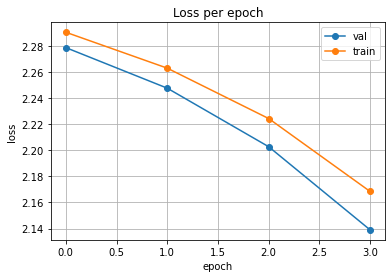

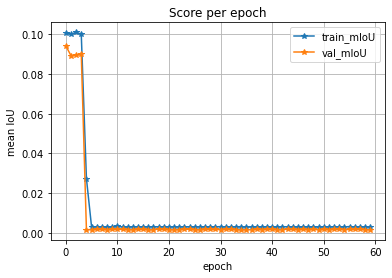

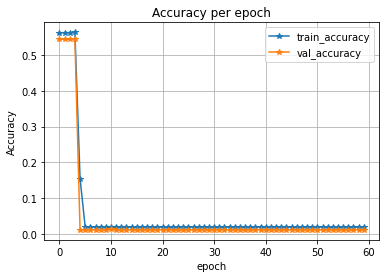

In [18]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [19]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '_lab.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(704,1056, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [20]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        score_per_class =  mIoU_per_class(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, score_per_class

In [21]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [22]:
image, mask = test_set[3]
pred_mask, score, Score_perclass = predict_image_mask_miou(model, image, mask)
print('mIoU score',score)
print('IoU per class', Score_perclass)

mIoU score 4.108684273038581e-15
IoU per class [nan, nan, 4.962926935789649e-16, nan, 7.046272873963313e-16, 6.17825501365394e-16, nan, 1.8294914013903802e-14, nan, 4.2976186894841554e-16]


In [23]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score, score_per_class = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [24]:
mob_miou = miou_score(model, test_set)
print('Test Set mIoU', np.mean(mob_miou))

  0%|          | 0/235 [00:00<?, ?it/s]

Test Set mIoU 0.007898073271669628


In [25]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [26]:
mob_acc = pixel_acc(model, test_set)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/235 [00:00<?, ?it/s]

Test Set Pixel Accuracy 0.022521285067185398


In [27]:
def miou_score_per_class(model, test_set):
    score_iou = []
    arr2 = np.zeros(10)
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score , score_perclass= predict_image_mask_miou(model, img, mask)
        arr2 = np.vstack([arr2, score_perclass])
        score_iou.append(score)
    return np.nanmean(arr2, axis=0)

In [28]:
mob_miou_per_class = miou_score_per_class(model, test_set)
print(mob_miou_per_class)

  0%|          | 0/235 [00:00<?, ?it/s]

[2.78552736e-01 1.53421482e-15 5.66416293e-15 3.90203746e-15
 6.00877370e-15 2.81245435e-15 3.01306885e-15 7.24949814e-14
 4.76604519e-14 3.03711503e-16]


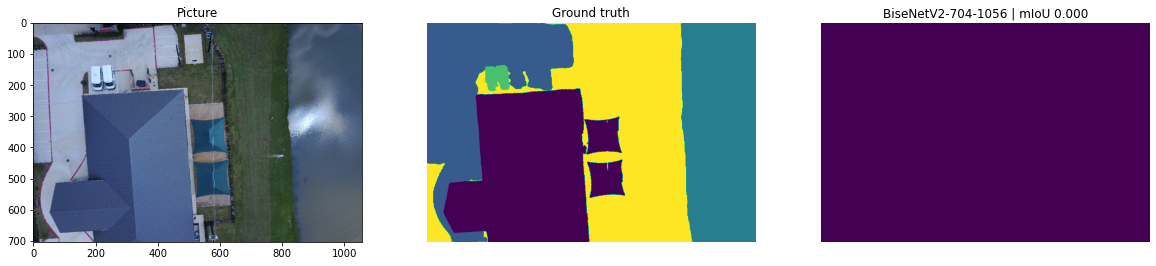

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('BiseNetV2-704-1056 | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

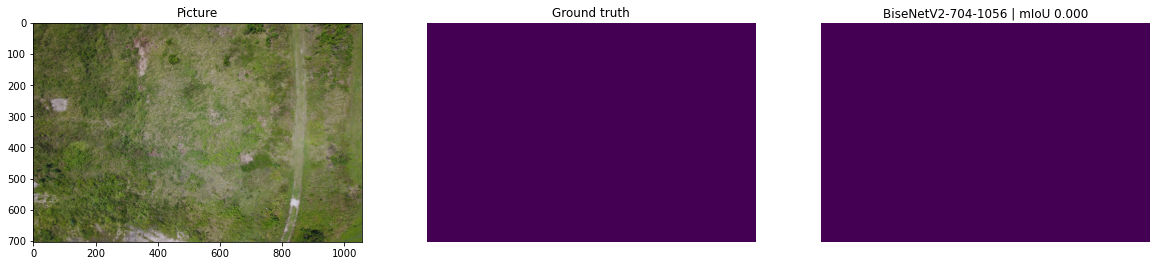

In [30]:
image2, mask2 = test_set[4]
pred_mask2, score2, score_class = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('BiseNetV2-704-1056 | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

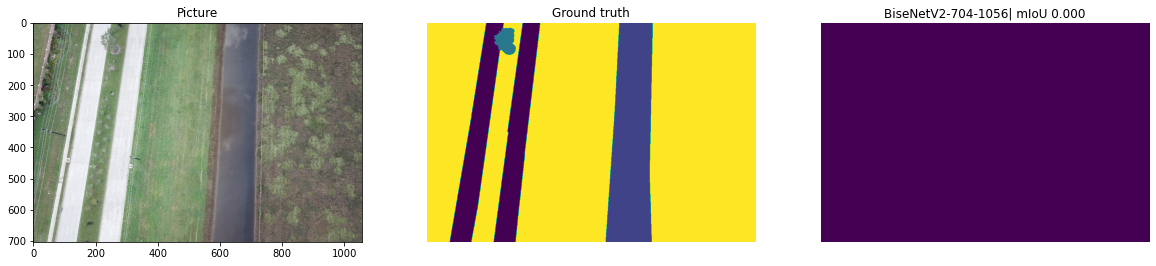

In [31]:
image3, mask3 = test_set[6]
pred_mask3, score3, score_clss = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('BiseNetV2-704-1056| mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [32]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.007898073271669628


In [33]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.022521285067185398


In [34]:
device = torch.device('cuda')
model.to(device)
dummy_input = torch.randn(1, 3,704,1056,dtype=torch.float).to(device)
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
#GPU-WARM-UP
for _ in range(10):
    _= model(dummy_input)
    
# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = model(dummy_input)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)

48.76913333892822


In [35]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [36]:
print(pytorch_total_params)

17040336


In [37]:
!pip install ptflops

In [38]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
    net = model
    macs, params = get_model_complexity_info(net, (3, 704,1056), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))

BiSeNetv2(
  0.021 M, 0.124% Params, 0.218 GMac, 100.000% MACs, 
  (detail_branch): DetailBranch(
    0.001 M, 0.008% Params, 0.112 GMac, 51.173% MACs, 
    (S1): Sequential(
      0.0 M, 0.002% Params, 0.071 GMac, 32.750% MACs, 
      (0): ConvModule(
        0.0 M, 0.001% Params, 0.036 GMac, 16.375% MACs, 
        (0): QConv2d(
          0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, 3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
          (quantize_input): QuantMeasure(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, )
        )
        (1): BatchNorm2d(0.0 M, 0.001% Params, 0.024 GMac, 10.917% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(0.0 M, 0.000% Params, 0.012 GMac, 5.458% MACs, inplace=True)
      )
      (1): ConvModule(
        0.0 M, 0.001% Params, 0.036 GMac, 16.375% MACs, 
        (0): QConv2d(
          0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi